<a href="https://colab.research.google.com/github/AKupriichuk/pr_Medical_Data_Visualizer/blob/main/medproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The objectives of this project include:

The objectives of this project include:

1. Conducting basic statistical analysis and testing for the normality of age distribution.
2. Analyzing the impact of cholesterol and glucose levels on age using categorical variables.
3. Performing non-parametric analysis of variance (Kruskal-Wallis test) to identify significant differences between groups based on cholesterol and glucose categories.
5. Performing correlation analysis to determine statistical relationships between different factors (age, weight, glucose level, etc.) and the risk of cardiovascular diseases.
6. Visualizing data using box plots, bar graphs, heatmaps, and correlation matrices.


In [60]:
!pip install pingouin

In [61]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg


In [62]:
# Import data
df = pd.read_csv('medical_examination.csv')

# 1) Basic statistics

In [63]:
print(df.head())
df.info()
print(df.describe())

   id    age  sex  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393    2     168    62.0    110     80            1     1      0   
1   1  20228    1     156    85.0    140     90            3     1      0   
2   2  18857    1     165    64.0    130     70            3     1      0   
3   3  17623    2     169    82.0    150    100            1     1      0   
4   4  17474    1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   sex          70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70

# 2) Normality testing of age distribution

since our age is in days, so for convenience I converted it to years

In [64]:
df['age_years'] = df['age'] / 365
df['age_years'].head()

0    50.391781
1    55.419178
2    51.663014
3    48.282192
4    47.873973
Name: age_years, dtype: float64

the normality test works fine up to 5000 observations, I have 70000 so I need to remove 65001 random rows and create new data frame (df_dropped)

In [65]:
indexes_to_drop = np.random.choice(df.index, 65001, replace=False)
df_dropped = df.drop(indexes_to_drop)
print(df_dropped.head())

    id    age  sex  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
22  32  23046    1     158    90.0    145     85            2     2      0   
24  35  16608    1     170    68.0    150     90            3     1      0   
31  43  23186    1     169    71.0    140     90            3     1      0   
32  44  14605    1     159    60.0    110     70            1     1      0   
41  56  18274    1     178    68.0    110     80            1     1      0   

    alco  active  cardio  age_years  
22     0       1       1  63.139726  
24     0       1       1  45.501370  
31     0       1       1  63.523288  
32     0       1       0  40.013699  
41     0       1       1  50.065753  


will output the information again to make sure it has up to 5000 rows

In [66]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 22 to 69978
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           4999 non-null   int64  
 1   age          4999 non-null   int64  
 2   sex          4999 non-null   int64  
 3   height       4999 non-null   int64  
 4   weight       4999 non-null   float64
 5   ap_hi        4999 non-null   int64  
 6   ap_lo        4999 non-null   int64  
 7   cholesterol  4999 non-null   int64  
 8   gluc         4999 non-null   int64  
 9   smoke        4999 non-null   int64  
 10  alco         4999 non-null   int64  
 11  active       4999 non-null   int64  
 12  cardio       4999 non-null   int64  
 13  age_years    4999 non-null   float64
dtypes: float64(2), int64(12)
memory usage: 585.8 KB


statistical tests for normality -  Shapiro-Wilk test

In [67]:
w_statistic, p_value = stats.shapiro(df_dropped['age_years'])
print(p_value)

1.5430935336182123e-31


In [68]:
pg.normality(df_dropped['age_years'])

,W,pval,normal
age_years,0.969006,1.543094e-31,False


for the two libraries we see one allocation value

 the distribution is not normal, because p_value < 0.05

Non-parametric Anova must be used

# 3)Analysis by "cholesterol" and "glucose" categories

I divide the data into categories (cholesterol level 1: normal, 2: higher than normal, 3: significantly higher than normal and glucose level 1: normal, 2: higher than normal, 3: significantly higher than normal, as a quantitative indicator - age)

In [69]:
import pandas as pd
from scipy.stats import f_oneway

# functions for basic statistic
def calculate_statistics(group):
    count = group.shape[0]
    mean = group['age_years'].mean()
    std = group['age_years'].std()
    return count, mean, std

# Division into groups by "cholesterol" category
ch1 = df_dropped[df_dropped["cholesterol"] == 1]
ch2 = df_dropped[df_dropped["cholesterol"] == 2]
ch3 = df_dropped[df_dropped["cholesterol"] == 3]
# Division into groups by "glucose" category
g1 = df_dropped[df_dropped["gluc"] == 1]
g2 = df_dropped[df_dropped["gluc"] == 2]
g3 = df_dropped[df_dropped["gluc"] == 3]

# Analysis by categorical variables
print("Analysis by category 'Cholesterol':")
print("1: normal")
count_ch1, mean_ch1, std_ch1 = calculate_statistics(ch1)
print("Number of observations:", count_ch1)
print("Average age:", mean_ch1)
print("Standard deviation of age:", std_ch1)

print("2: above normal")
count_ch2, mean_ch2, std_ch2 = calculate_statistics(ch2)
print("Number of observations:", count_ch2)
print("Average age:", mean_ch2)
print("Standard deviation of age:", std_ch2)

print("3: well above normal")
count_ch3, mean_ch3, std_ch3 = calculate_statistics(ch3)
print("Number of observations:", count_ch3)
print("Average age:", mean_ch3)
print("Standard deviation of age:", std_ch3)

print("\nAnalysis by category 'Glucose':")
print("1: normal")
count_g1, mean_g1, std_g1 = calculate_statistics(g1)
print("Number of observations:", count_g1)
print("Average age:", mean_g1)
print("Standard deviation of age:", std_g1)

print("2: above normal")
count_g2, mean_g2, std_g2 = calculate_statistics(g2)
print("Number of observations:", count_g2)
print("Average age:", mean_g2)
print("Standard deviation of age:", std_g2)

print("3: well above normal")
count_g3, mean_g3, std_g3 = calculate_statistics(g3)
print("Number of observations:", count_g3)
print("Average age:", mean_g3)
print("Standard deviation of age:", std_g3)




Analysis by category 'Cholesterol':
1: normal
Number of observations: 3711
Average age: 52.7889310934172
Standard deviation of age: 6.68072160520346
2: above normal
Number of observations: 707
Average age: 53.70578365077212
Standard deviation of age: 6.6103228037327435
3: well above normal
Number of observations: 581
Average age: 56.41822554405489
Standard deviation of age: 5.449736904438062

Analysis by category 'Glucose':
1: normal
Number of observations: 4256
Average age: 53.09557176331239
Standard deviation of age: 6.663555334081175
2: above normal
Number of observations: 368
Average age: 53.94437164979154
Standard deviation of age: 6.752558380458132
3: well above normal
Number of observations: 375
Average age: 55.52645114155251
Standard deviation of age: 5.7897491392922396


The average value in the groups is different

visualization of groups

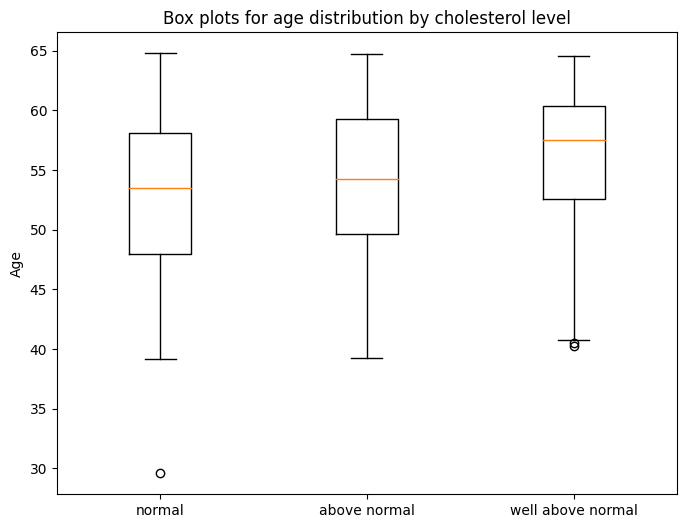

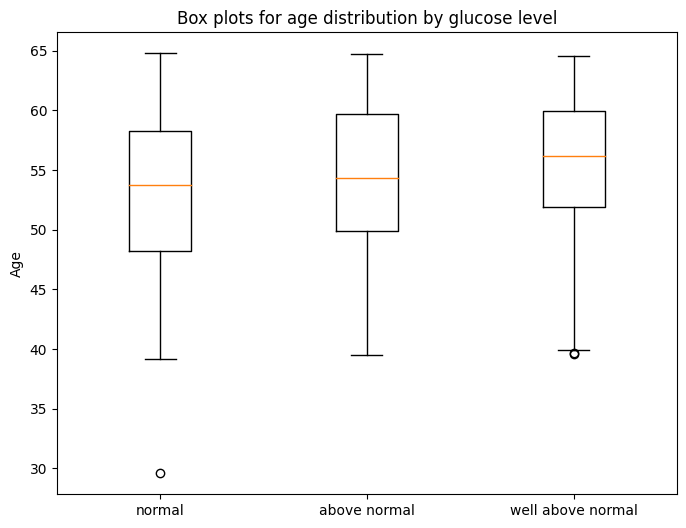

In [70]:
# Division into groups by "cholesterol" category
ch1 = df_dropped[df_dropped["cholesterol"] == 1]
ch2 = df_dropped[df_dropped["cholesterol"] == 2]
ch3 = df_dropped[df_dropped["cholesterol"] == 3]

# Division into groups by "glucose" category
g1 = df_dropped[df_dropped["gluc"] == 1]
g2 = df_dropped[df_dropped["gluc"] == 2]
g3 = df_dropped[df_dropped["gluc"] == 3]

# Creating lists for box plots
groups_ch = [ch1['age_years'], ch2['age_years'], ch3['age_years']]
groups_g = [g1['age_years'], g2['age_years'], g3['age_years']]

# Construction of box plots

# For sex (Sex)
plt.figure(figsize=(8, 6))
plt.boxplot(groups_ch, labels=['normal', 'above normal', 'well above normal'])
plt.title("Box plots for age distribution by cholesterol level")
plt.ylabel("Age")
plt.show()

# For the diagnosis of resting electrocardiogram (RestingECG)
plt.figure(figsize=(8, 6))
plt.boxplot(groups_g, labels=['normal', 'above normal', 'well above normal'])
plt.title("Box plots for age distribution by glucose level")
plt.ylabel("Age")
plt.show()

Here we see the same thing, the average value is different



# Kruskal-Wallis test

Now I'm doing an analysis

 hypotheses:


H0 - null hypothesis that all groups have the same
average values.

H1 - there are statistically significant differences between
average values

In [71]:
from scipy.stats import kruskal


h_value, p_value = kruskal(ch1['age_years'], ch2['age_years'], ch3['age_years'])

print("H-значение:", h_value)
print("p-значение:", p_value)


H-значение: 149.47569439895435
p-значение: 3.4814917625226514e-33


According to the non-parametric Anova (Kruskal-Wallis) test, I reject the 0 hypothesis

In [72]:
from scipy.stats import kruskal


h_value, p_value = kruskal(g1['age_years'], g2['age_years'], g3['age_years'])

print("H-значение:", h_value)
print("p-значение:", p_value)


H-значение: 49.74640260407676
p-значение: 1.5765433872850645e-11


another group, the result of the same, we reject the 0 hypothesis

# working with the initial dataset

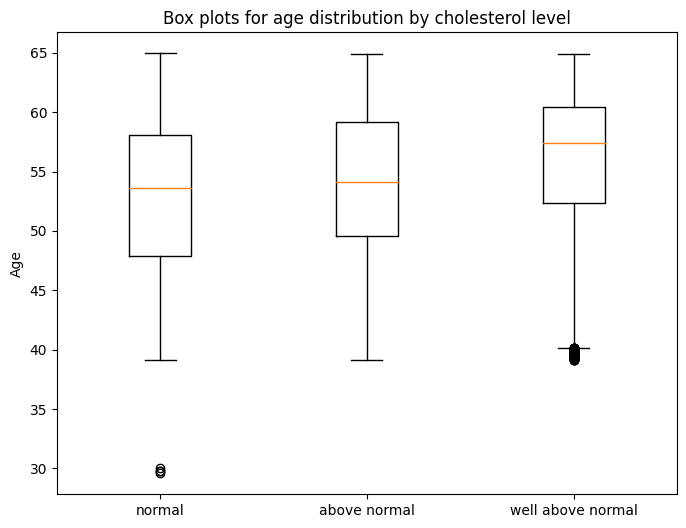

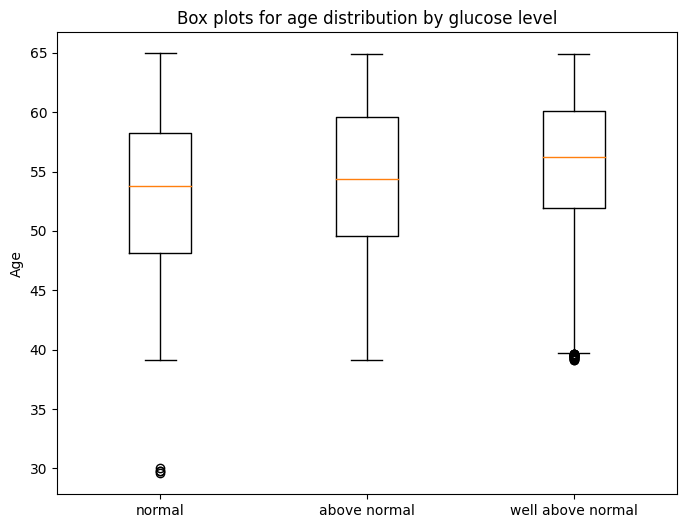

In [73]:
# Division into groups by "cholesterol" category
ch1 = df[df["cholesterol"] == 1]
ch2 = df[df["cholesterol"] == 2]
ch3 = df[df["cholesterol"] == 3]

# Division into groups by "glucose" category
g1 = df[df["gluc"] == 1]
g2 = df[df["gluc"] == 2]
g3 = df[df["gluc"] == 3]

# Creating lists for box plots
groups_ch = [ch1['age_years'], ch2['age_years'], ch3['age_years']]
groups_g = [g1['age_years'], g2['age_years'], g3['age_years']]

# Construction of box plots

plt.figure(figsize=(8, 6))
plt.boxplot(groups_ch, labels=['normal', 'above normal', 'well above normal'])
plt.title("Box plots for age distribution by cholesterol level")
plt.ylabel("Age")
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(groups_g, labels=['normal', 'above normal', 'well above normal'])
plt.title("Box plots for age distribution by glucose level")
plt.ylabel("Age")
plt.show()

# Also non-parametric ANOVA






H0 - null hypothesis that all groups have the same
average values.

H1 - there are statistically significant differences between
average values

In [77]:
from scipy.stats import kruskal
h_value, p_value = kruskal(g1['age_years'], g2['age_years'], g3['age_years'])

print("H-значение:", h_value)
print("p-значение:", p_value)


H-значение: 699.4875584456599
p-значение: 1.2829407609358133e-152


is confirmed by H1

In [78]:
from scipy.stats import kruskal
h_value, p_value = kruskal(ch1['age_years'], ch2['age_years'], ch3['age_years'])

print("H-значение:", h_value)
print("p-значение:", p_value)


H-значение: 1760.540984377018
p-значение: 0.0


is also confirmed by H1

# 4)Correlation

In [79]:
df_heat = df[(df['ap_lo'] <= df['ap_hi']) &
             (df['height'] >= df['height'].quantile(0.025)) &
             (df['height'] <= df['height'].quantile(0.975)) &
             (df['weight'] >= df['weight'].quantile(0.025)) &
             (df['weight'] <= df['weight'].quantile(0.975))
             ]

# Calculate the correlation matrix
corr = df_heat.corr()

print(corr)



                   id       age       sex    height    weight     ap_hi  \
id           1.000000  0.002507  0.003426  0.000326  0.000149  0.003492   
age          0.002507  1.000000 -0.018132 -0.076932  0.070168  0.018689   
sex          0.003426 -0.018132  1.000000  0.505785  0.129979  0.005063   
height       0.000326 -0.076932  0.505785  1.000000  0.251503  0.004586   
weight       0.000149  0.070168  0.129979  0.251503  1.000000  0.027030   
ap_hi        0.003492  0.018689  0.005063  0.004586  0.027030  1.000000   
ap_lo        0.000484  0.153508  0.059947  0.017922  0.227922  0.072803   
cholesterol  0.005581  0.154642 -0.038756 -0.065980  0.137705  0.021499   
gluc         0.002242  0.097646 -0.023419 -0.028364  0.094133  0.010226   
smoke       -0.002732 -0.044371  0.337436  0.187830  0.056533 -0.001928   
alco        -0.000708 -0.026970  0.168637  0.089785  0.059917  0.000769   
active       0.005891 -0.011445  0.007864 -0.005661 -0.014430 -0.000222   
cardio       0.003900  0.

# 5)correlation matrix

In [80]:
import plotly.io as pio
import plotly.express as px
df_heat = df[(df['ap_lo'] <= df['ap_hi']) &
             (df['height'] >= df['height'].quantile(0.025)) &
             (df['height'] <= df['height'].quantile(0.975)) &
             (df['weight'] >= df['weight'].quantile(0.025)) &
             (df['weight'] <= df['weight'].quantile(0.975))
             ]

fig6 = px.imshow(df_heat.corr(),
                 color_continuous_scale='sunset',
                 )
fig6.show()

Statistical correlation between variables

Strong correlation:

Age has a moderate positive correlation with the presence of cardiovascular diseases (0.24). This is expected as the risk of developing cardiovascular diseases increases with age.
The positive correlation between height and gender also reflects the biological link between these two factors (0.51).
Weight has a moderate positive correlation with the presence of cardiovascular diseases (0.17).

Glucose level and smoking show weak correlations with the presence of cardiovascular diseases.
Alcohol consumption and level of physical activity also have weak correlations with the presence of cardiovascular diseases.